# Give Me Some Credit

* ### __Set 1: [Classifiers]__ [Due by 3.22 Wed]
  * The goal of this HW is to be familiar with the basic classifiers __PML__ Ch 3. 
  * For this HW, we will use [Give Me Some Credit]([http://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data](https://www.kaggle.com/datasets/brycecf/give-me-some-credit-dataset)) on Kaggle. You may download from Kaggle link or CMS.
  * Load `cs-training.csv` into a Pandas dataframe.
  * Fill-in the missing values (`nan`) with the column means. (Use `pd.fillna()` or See Ch 4 of `PML`)
  * Select the 2 most important features using LogisticRegression with L1 penalty. (Adjust C until you see 2 features)
  * Using the 2 selected features, apply LR / SVM / decision tree. Try your own hyperparameters (C, gamma, tree depth, etc) to maximize the prediction accuracy. (Just try several values. You don't need to show your answer is the maximum.)
  * Visualize your classifiers using the `plot_decision_regions` function from __PML__ Ch. 3
  * Put your result in `YOUR_GITHUB_ID/Give-Me-Some-Credit/code/Classifiers.ipynb`
* ### __Set 2: [PCA/Hyperparameter/CV]__ [Due by 3.29 Wed]
  * The goal of this HW is to be familiar with PCA (feature extraction), grid search, pipeline, k-fold CV. 
  * For this HW, we continue to use [Give Me Some Credit]([http://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data](https://www.kaggle.com/datasets/brycecf/give-me-some-credit-dataset)) on Kaggle. 
  * Extract a few (>2) features using PCA method.
  * Using the selected features from above, we are going to apply LR / SVM / decision tree (or any other algorithm). 
  * Implement the methods using pipeline. (__PML__ p185)
  * Use grid search for finding optimal hyperparameters. (__PML__ p199). In the search, apply 5-fold cross-validation.

## Importing libraries and data

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier


# To check recent matplotlib compatibility
import matplotlib
from distutils.version import LooseVersion

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('magenta', 'blue', 'lightgreen', 'red', 'blue')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    color=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        
        if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):
            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100, 
                        label='test set')
        else:
            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='none',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100, 
                        label='test set')        

In [39]:
#importing training data to pandas dataframe

df=pd.read_csv('cs-training.csv')
#dftest=pd.read_csv('cs-test.csv')
print(df.shape)

dfy=df.iloc[:,1:2] #set the target column separate from dataframe
df=df.iloc[:,2:] #featuresx
df.fillna(df.mean(),inplace=True)
X=df.values
y=dfy.values
df

(150000, 12)


,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.766127,45,2,0.802982,9120.000000,13,0,6,0,2.0
1,0.957151,40,0,0.121876,2600.000000,4,0,0,0,1.0
2,0.658180,38,1,0.085113,3042.000000,2,1,0,0,0.0
3,0.233810,30,0,0.036050,3300.000000,5,0,0,0,0.0
4,0.907239,49,1,0.024926,63588.000000,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...
149995,0.040674,74,0,0.225131,2100.000000,4,0,1,0,0.0
149996,0.299745,44,0,0.716562,5584.000000,4,0,1,0,2.0
149997,0.246044,58,0,3870.000000,6670.221237,18,0,1,0,0.0
149998,0.000000,30,0,0.000000,5716.000000,4,0,0,0,0.0


Split the data

(100000, 10)
(50000, 10)
(100000, 1)
(50000, 1)


(array([93316.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  6684.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

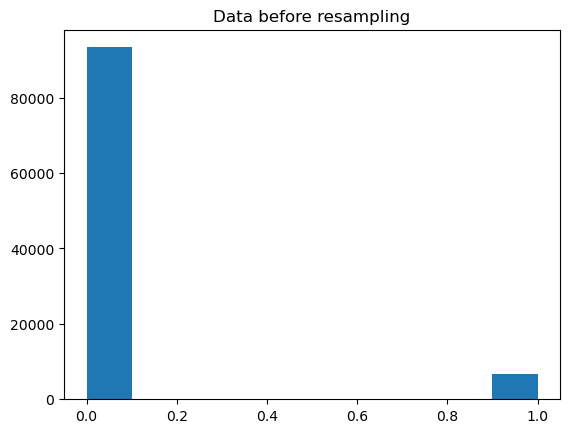

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=1/3, random_state=1, stratify=y)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

plt.title('Data before resampling')
plt.hist(y_train)
#plt.savefig('images/data_beforeresample_dist.png', dpi=300)

### Dealing with class imbalance

In [41]:
from sklearn.utils import resample

print('Number of class 1 examples before:', X_train[y_train == 1].shape)

X_upsampled, y_upsampled = resample(X_train[y_train == 1],
                                    y_train[y_train == 1],
                                    replace=True,
                                    n_samples=X_train[y_train == 0].shape[0],
                                    random_state=123)

print('Number of class 1 examples after:', X_upsampled.shape)
#print('Number of class 1 examples after:', y_upsampled.shape)

Number of class 1 examples before: (6684, 10)
Number of class 1 examples after: (93316, 10)


(100000, 10)
(93316, 10)
(100000, 1)
(93316,)


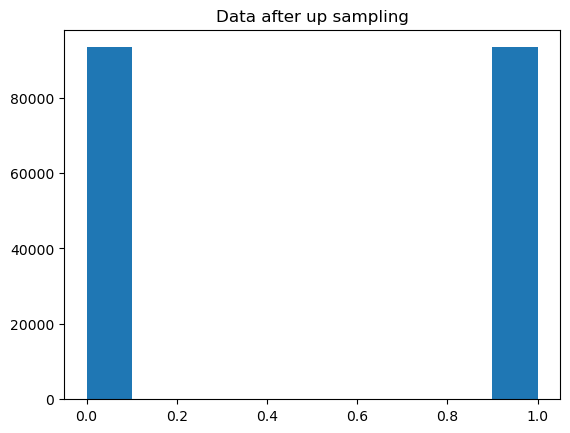

In [35]:
#UPSAMPLE


print(X_train.shape)
print(X_upsampled.shape)
print(y_train.shape)
print(y_upsampled.shape)

X_bal = np.vstack((X_train[y_train==0], X_upsampled))
y_bal = np.hstack((y_train[y_train==0], y_upsampled))

#check the data label balance
plt.title('Data after up sampling')
plt.hist(y_bal)
#plt.savefig('images/data_upsample_dist.png', dpi=300)

Number of class 1 examples before: (93316, 10)
Number of class 1 examples after: (6684, 10)


(array([6684.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        6684.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

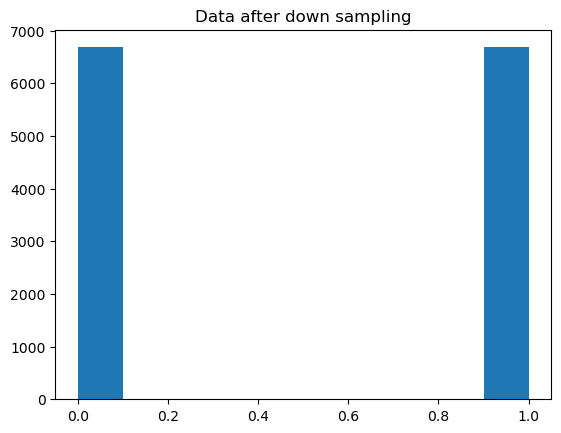

In [42]:
#DOWNSAMPLE

from sklearn.utils import resample

print('Number of class 1 examples before:', X_train[y_train == 0].shape)

X_downsampled, y_downsampled = resample(X_train[y_train == 0],
                                    y_train[y_train == 0],
                                    replace=True,
                                    n_samples=X_train[y_train == 1].shape[0],
                                    random_state=123)

print('Number of class 1 examples after:', X_downsampled.shape)
#print('Number of class 1 examples after:', y_upsampled.shape)

X_bal = np.vstack((X_train[y_train==1], X_downsampled))
y_bal = np.hstack((y_train[y_train==1], y_downsampled))

#check the data label balance
plt.title('Data after down sampling')
plt.hist(y_bal)
#plt.savefig('images/data_downsample_dist.png', dpi=300)

### Combining transformers and estimators in a pipeline

### Finding the optimum hyperparameter using gridsearch for SVM, LR, and Decision Tree

In [32]:
#Logistic regression grid search

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=3),
                        LogisticRegression(random_state=1, solver='lbfgs'))

param_range = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'logisticregression__C': param_range}]
gs = GridSearchCV(estimator=pipe_lr, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=5,
                  n_jobs=-1)
gs = gs.fit(X_bal, y_bal)
print(gs.best_score_)
print(gs.best_params_)


'''
0.6946431264639525
{'logisticregression__C': 10.0}
'''

0.6946431264639525
{'logisticregression__C': 10.0}


"\n0.6946431264639525\n{'logisticregression__C': 10.0}\n"

In [6]:
#Decision tree grid search

pipe_dt = make_pipeline(StandardScaler(),
                        PCA(n_components=3),
                        DecisionTreeClassifier(random_state=1))

param_range = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'decisiontreeclassifier__max_depth': param_range,'decisiontreeclassifier__criterion': ['entropy','gini']}]

gs = GridSearchCV(estimator=pipe_dt, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=5,
                  n_jobs=-1)
gs = gs.fit(X_bal, y_bal)
print(gs.best_score_)
print(gs.best_params_)


'''
0.7048177276798568
{'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 10.0}
'''

0.7048177276798568
{'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 10.0}


"\n0.7048177276798568\n{'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 10.0}\n"

In [8]:
#SVC grid search
pipe_svc = make_pipeline(StandardScaler(),PCA(n_components=3),
                         SVC(random_state=1,kernel='linear'))

param_range = [1.0, 10.0, 100.0]

param_grid = [{'svc__C': param_range}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=5,
                  n_jobs=-1)
gs = gs.fit(X_bal, y_bal)
print(gs.best_score_)
print(gs.best_params_)

'''
0.7153645656263456
{'svc__C': 10.0}
'''

0.7153645656263456
{'svc__C': 10.0}


# Majority Vote Classifier
### Based on tuned hyperparameter

In [7]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='classlabel')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        y : array-like, shape = [n_examples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_examples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_examples, n_classes]
            Weighted average probability for each class per example.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out['%s__%s' % (name, key)] = value
            return out

In [29]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(penalty='l2', 
                          C=10,
                          solver='lbfgs',
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=10,
                              criterion='entropy',
                              random_state=1)

clf3 = SVC(random_state=1,kernel='linear',C=10,probability=True)

pipe1 = Pipeline([['sc', StandardScaler()],['pca',PCA(n_components=3)],
                  ['clf', clf1]])
pipe2 = Pipeline([['sc', StandardScaler()],['pca',PCA(n_components=3)],
                  ['clf', clf2]])
pipe3 = Pipeline([['sc', StandardScaler()],['pca',PCA(n_components=3)],
                  ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'SVC']

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority voting']
all_clf = [pipe1, pipe2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_bal,
                             y=y_bal,
                             cv=5,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.5f) [%s]"
          % (scores.mean(), scores.std(), label))
    
'''
ROC AUC: 0.77 (+/- 0.00418) [Logistic regression]
ROC AUC: 0.75 (+/- 0.00615) [Decision tree]
ROC AUC: 0.78 (+/- 0.00497) [SVC]
ROC AUC: 0.84 (+/- 0.00827) [Majority voting]
'''    

ROC AUC: 0.77 (+/- 0.00418) [Logistic regression]
ROC AUC: 0.75 (+/- 0.00615) [Decision tree]
ROC AUC: 0.78 (+/- 0.00497) [SVC]
ROC AUC: 0.84 (+/- 0.00827) [Majority voting]


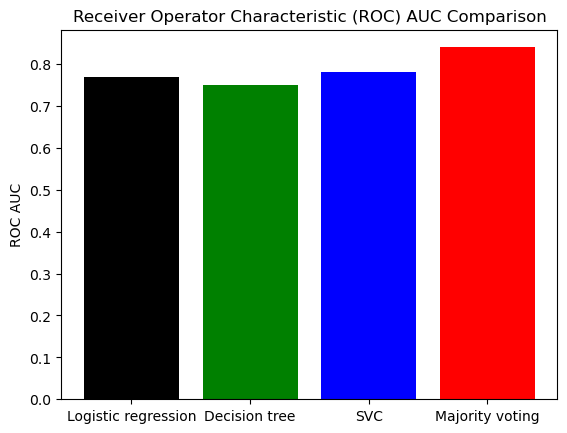

In [70]:
roc_label=['Logistic regression','Decision tree','SVC','Majority voting']
roc_val=[.77,.75,.78,.84]

plt.ylabel('ROC AUC')
plt.bar(roc_label,height=roc_val,color=['black','green','blue','red'])

plt.title('Receiver Operator Characteristic (ROC) AUC Comparison')
plt.savefig('images/ROC_AUC.png', dpi=300)

### Evaluating and tuning the ensemble classifier

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warni

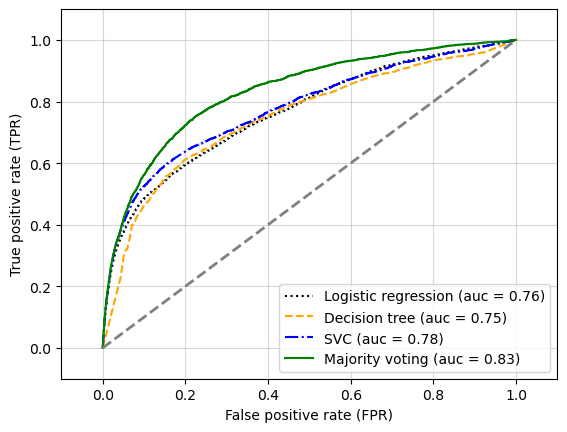

In [28]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_bal,y_bal).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.savefig('images/TPRvsFPR.png', dpi=300)
plt.show()

[[46052   606]
 [ 2715   627]]


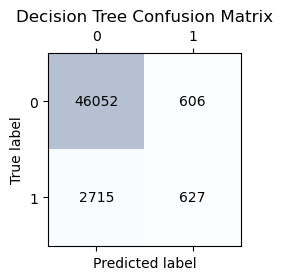

In [33]:
from sklearn.metrics import confusion_matrix

pipe_dt = make_pipeline(StandardScaler(),
                        PCA(n_components=3),
                        DecisionTreeClassifier(max_depth=10,criterion='entropy',random_state=1))

pipe_dt.fit(X_train, y_train)
y_pred = pipe_dt.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.title('Decision Tree Confusion Matrix')
#plt.savefig('images/confusion_matrix_dt.png', dpi=300)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[46615    43]
 [ 3292    50]]


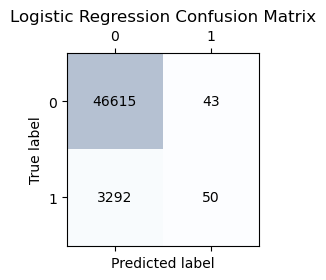

In [34]:
from sklearn.metrics import confusion_matrix

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=3),
                        LogisticRegression(C=10,random_state=1, solver='lbfgs'))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.title('Logistic Regression Confusion Matrix')
#plt.savefig('images/confusion_matrix_lr.png', dpi=300)
plt.show()

# Experimental Code Area

### Learning curve

In [15]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


pipe_lr = make_pipeline(StandardScaler(),PCA(n_components=2),
                        LogisticRegression(penalty='l2', random_state=1,
                                           solver='lbfgs', max_iter=10000))

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_bal,
                               y=y_bal,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

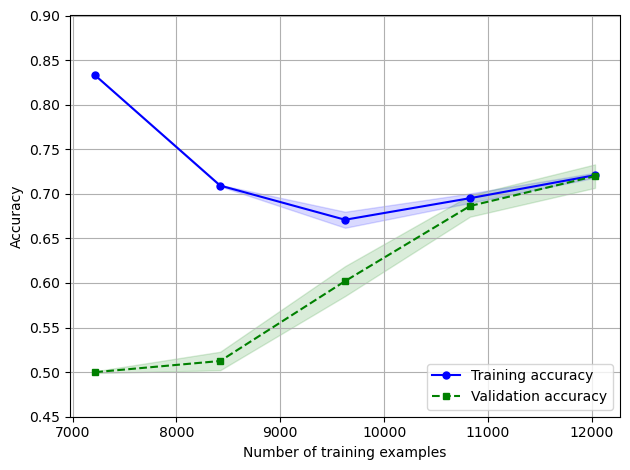

In [16]:
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.45, 0.9])
plt.tight_layout()
#plt.savefig('images/learning_curve.png', dpi=300)
plt.show()

In [17]:
from sklearn.model_selection import validation_curve


param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_bal, 
                y=y_bal, 
                param_name='logisticregression__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

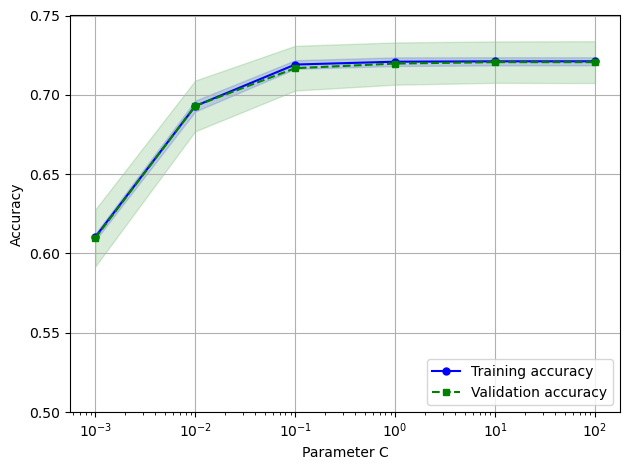

In [18]:
plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.5, .75])
plt.tight_layout()
#plt.savefig('images/validation_curve.png', dpi=300)
plt.show()

### Tuning hyperparameters via grid search testing

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pipe_svc = make_pipeline(StandardScaler(),PCA(n_components=2),
                         SVC(random_state=1))

param_range = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_bal, y_bal)
print(gs.best_score_)
print(gs.best_params_)

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=3),
                        LogisticRegression(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'logisticregression__C': param_range}]

gs = GridSearchCV(estimator=pipe_lr, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_bal, y_bal)
print(gs.best_score_)
print(gs.best_params_)

0.7206005154985466
{'logisticregression__C': 10.0}
